# K-Space Noise Levels

torch.Size([16, 1, 128, 128]) torch.Size([1000, 16, 1, 128, 128]) torch.Size([1000, 16, 1, 128, 128])


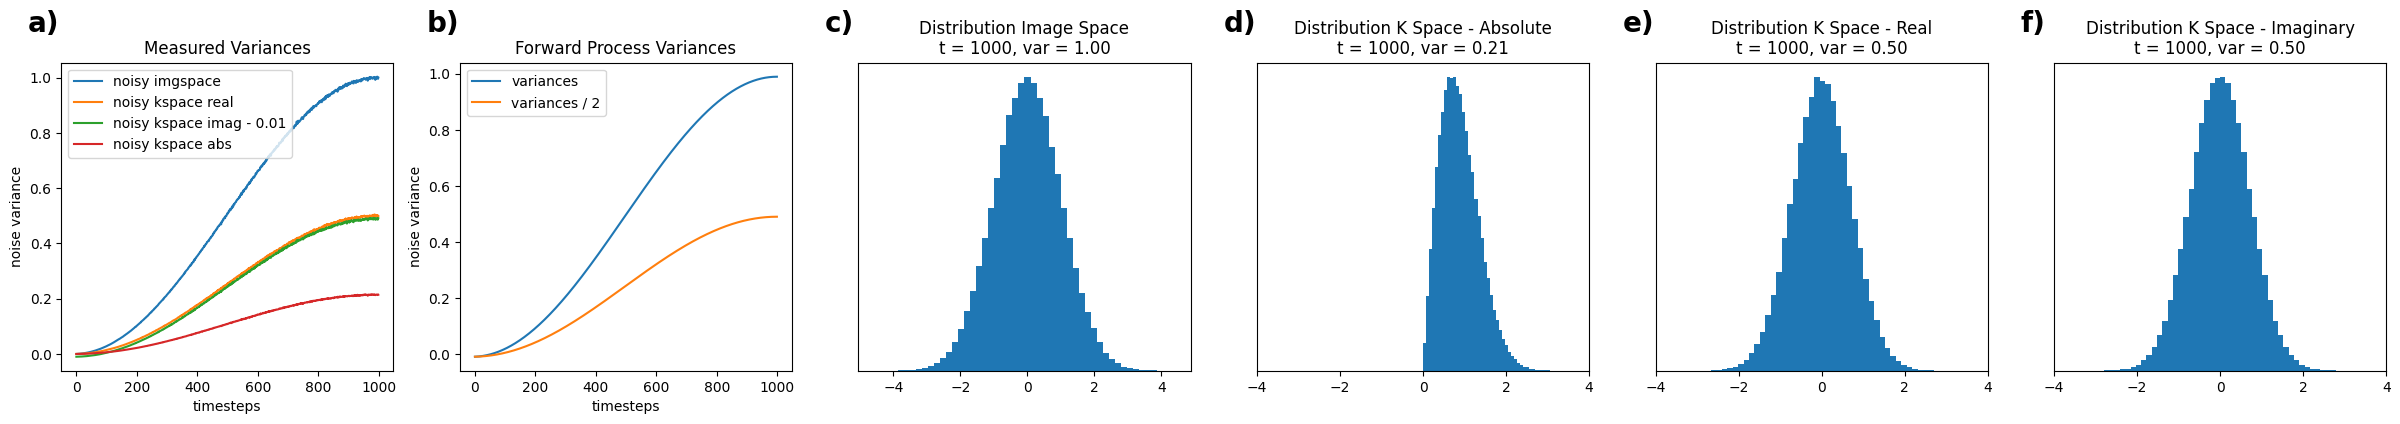

In [1]:
import sys
sys.path.append("../../diffusion_models/")
from models.diffusion import ForwardDiffusion
from sampler_dutifulpond10 import get_samples
import torch
from torch.fft import fftn, ifftn, fftshift
import matplotlib.pyplot as plt
import string

fwd = ForwardDiffusion(timesteps=1000, type="cosine")
samples = torch.zeros((16,1,128,128))
noisies = torch.zeros_like(samples).unsqueeze(0).repeat(fwd.timesteps, 1, 1, 1, 1)
noisies_k = torch.zeros_like(noisies, dtype=torch.complex64)

print(samples.shape, noisies.shape, noisies_k.shape)

for t in range(fwd.timesteps):
    t_long = t * torch.ones((samples.shape[0]), dtype=torch.long)
    noisies[t], _ = fwd(samples, t_long)
    noisies_k[t] = fftshift(fftn(noisies[t], dim=(-2,-1), norm="ortho"), dim=(-2,-1))

sample = noisies[-1]
sample_k = noisies_k[-1]

noisies = torch.var(noisies.squeeze(2).view(fwd.timesteps, 16*128*128), dim=-1)

noisies_k_abs = torch.var(torch.abs(noisies_k).squeeze(2).view(fwd.timesteps, 16*128*128), dim=-1)
noisies_k_real = torch.var(torch.real(noisies_k).squeeze(2).view(fwd.timesteps, 16*128*128), dim=-1)
noisies_k_imag = torch.var(torch.imag(noisies_k).squeeze(2).view(fwd.timesteps, 16*128*128), dim=-1)

xticks = [-4, -2, 0, 2, 4]

fig, axs = plt.subplots(1,6, figsize=(30,4))
for i,ax in enumerate(axs):
    if i == 0:
        ax.plot(noisies, label="noisy imgspace")
        ax.plot(noisies_k_real, label="noisy kspace real")
        ax.plot(noisies_k_imag - 0.01, label="noisy kspace imag - 0.01")
        ax.plot(noisies_k_abs, label="noisy kspace abs")
        ax.legend()
        ax.set_xlabel("timesteps")
        ax.set_ylabel("noise variance")
        ax.set_title("Measured Variances")
    elif i == 1:
        ax.plot(fwd.sqrt_one_minus_alphas_dash**2 - 0.01, label="variances")
        ax.plot(fwd.sqrt_one_minus_alphas_dash**2 / 2 - 0.01, label="variances / 2")
        ax.legend()
        ax.set_xlabel("timesteps")
        ax.set_ylabel("noise variance")
        ax.set_title("Forward Process Variances")
    elif i == 2:
        ax.hist(sample.view(-1), bins=50)
        ax.set_title(f"Distribution Image Space\nt = 1000, var = {torch.var(sample.view(-1)):.2f}")
        ax.set_xticks(xticks)
        ax.set_yticks([])
    elif i == 3:
        ax.hist(torch.abs(sample_k).view(-1), bins=50)
        ax.set_title(f"Distribution K Space - Absolute\nt = 1000, var = {torch.var(torch.abs(sample_k).view(-1)):.2f}")
        ax.set_xticks(xticks)
        ax.set_yticks([])
    elif i == 4:
        ax.hist(torch.real(sample_k).view(-1), bins=50)
        ax.set_title(f"Distribution K Space - Real\nt = 1000, var = {torch.var(torch.real(sample_k).view(-1)):.2f}")
        ax.set_xticks(xticks)
        ax.set_yticks([])
    elif i == 5:
        ax.hist(torch.imag(sample_k).view(-1), bins=50)
        ax.set_title(f"Distribution K Space - Imaginary\nt = 1000, var = {torch.var(torch.imag(sample_k).view(-1)):.2f}")
        ax.set_xticks(xticks)
        ax.set_yticks([])
for n,elem in enumerate(axs.reshape(-1)):
    elem.text(-0.1, 1.1, string.ascii_lowercase[n]+")", transform=elem.transAxes, size=20, weight='bold')

In [31]:
torch.std(torch.var(sample_k).view(-1))

tensor(nan)

In [32]:
torch.var(sample_k)

tensor(1.0012)